<a href="https://colab.research.google.com/github/sebgrijalva/Cirq-code/blob/master/QOSF/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install cirq
import random
import cirq

     |████████████████████████████████| 1.2MB 2.8MB/s 
     |████████████████████████████████| 1.8MB 19.3MB/s 
     |████████████████████████████████| 1.2MB 19.0MB/s 
     |████████████████████████████████| 5.3MB 34.8MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556408 sha256=c39a1601b2067714356c889e83e72c98bfdc41ae66f13437b52bcb60f2b42d9b
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: networkx 2.4
    Uninstalling networkx-2.4:
      Successfully uninstalled networkx-2.4
  Found existing installation: protobuf 3.10.0
    Uninstalling protobuf-3.10.0:
      Successfully uninstalled protobuf-3.10.0
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


In [0]:
#needed for classical post-processing and evaluation;
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

iteration 1: parameter = -0.1943515732293288, error = 0.6400000000000001
iteration 2: parameter = 1.1282484267706712, error = 0.15999999999999998
iteration 3: parameter = 1.2130484267706712, error = 0.6400000000000001
iteration 4: parameter = 0.8882484267706711, error = 0.3600000000000001
iteration 5: parameter = 1.071048426770671, error = 0.0
iteration 6: parameter = 1.074648426770671, error = 0.6400000000000001
iteration 7: parameter = 0.748248426770671, error = 1.0
iteration 8: parameter = 0.244648426770671, error = 0.6400000000000001
iteration 9: parameter = 0.5682484267706711, error = 1.0
iteration 10: parameter = 0.06464842677067106, error = 0.91
iteration 11: parameter = 0.520548426770671, error = 0.15999999999999998
iteration 12: parameter = 0.6080484267706711, error = 0.6400000000000001
iteration 13: parameter = 0.28324842677067097, error = 0.6400000000000001
iteration 14: parameter = 0.28324842677067097, error = 1.0
iteration 15: parameter = -0.22035157322932908, error = 1.0


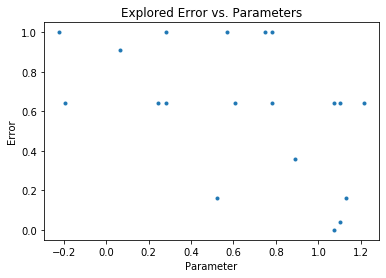

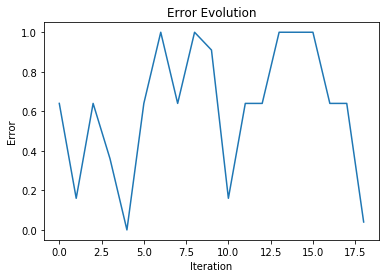

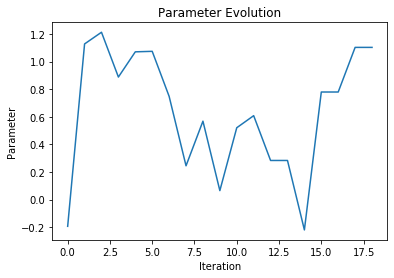

In [6]:
def main(qubit_count = 2):

    n_samples = 10
    parameter = np.pi*(2*random.random()-1) #starting with our parameter somewhere btw -pi,pi

    error_data = []
    parameter_data = [parameter]
    error = 0.9
    step = 0.01 #for gradient descent

    # Choose qubits to use.
    input_qubits = [cirq.GridQubit(0,0),cirq.GridQubit(0, 1)]
    
    scanning = True
    iterations = 1
    while scanning and iterations < 100:
        # Build circuit (with updated parameter):
        circuit = make_circuit(input_qubits, parameter)


        data=[] #we'll store here the results of the sampling

        # Sampling:
        ##############################################################
        for _ in range(n_samples):
            
            simulator = cirq.Simulator()
            results = simulator.run(circuit).measurements['result'][0]
            #print(results)
            data.append(str(results))
        

        #print(data)
        freqs = Counter(data)
            
        #Classical Post-Processing:   
        ##############################################################

        #Objective function is to cancel the amplitudes of the |01> and |10> states and to have the others equal.
        new_error = freqs['[0 1]']/n_samples + freqs['[1 0]']/n_samples + (freqs['[0 0]']/n_samples - freqs['[1 1]']/n_samples)**2
        
        error_data.append(new_error)
        print(f'iteration {iterations}: parameter = {parameter}, error = {new_error}')
        if new_error < 0.05 and iterations > 10: 
            scanning = False
        else: 
            # go against max descent and big error. If True, force symmetric state |00> + |11>. If False, force antisymmetric state |00> - |11>
            parameter += - step*(new_error - error) - 0.5*np.sign(new_error - error)*new_error + get_sym_state(parameter,True)
            error = new_error
            parameter_data.append(parameter)

        iterations += 1

    #Show Results:
    ######################################################    
    print('\n',freqs,'\n')  # get an idea of what was the final frequency count
    print('Circuit:')
    print(circuit,'\n','Details:')

    plt.figure(0)
    plt.title('Explored Error vs. Parameters')
    plt.xlabel('Parameter')
    plt.ylabel('Error')
    plt.plot(parameter_data[:len(error_data)], error_data,'.')

    plt.figure(1)
    plt.title('Error Evolution')
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.plot(range(len(error_data)),error_data)
            
    plt.figure(2)
    plt.title('Parameter Evolution')
    plt.xlabel('Iteration')
    plt.ylabel('Parameter')
    plt.plot(range(len(parameter_data)),parameter_data)
    
    
def get_sym_state(parameter, choice):
    if choice:
        return np.heaviside(-parameter,0)
    else:
        return - np.sign(parameter)*np.heaviside(parameter,0) 


def make_circuit(qubits,theta):
    """Generates a state with equal probability of being in |00> and |11>"""

    c = cirq.Circuit()
    
    c.append([
        # add noise (5% probability of getting some Pauli gates scrambling our system)
        cirq.DepolarizingChannel(0.05).on(qubits[0]), 
        cirq.DepolarizingChannel(0.05).on(qubits[1]),
        
        # put gates in the circuit
        cirq.ry(theta)(qubits[0]),
        cirq.CNOT(qubits[0],qubits[1]),

        # measure state
        cirq.measure(*qubits, key='result')
    ])

    return c

if __name__ == '__main__':
    main()